# Big Data Term Project
### 191805040	Muhammed Esad YALCIN (Team Leader)
### 181805024	Hamza KAPLAN
### 181805057	Kardelen Gel 
### 181805067	Buse Latife Beker

## Project Description
This project is about using collaborative filtering on pyspark with training model of ALS.
We have two csv datasheets which are "movies" and "ratings".
Object is train the model and build a recommendation engine based on ratings that each user gave.
The model has multiple parameters so, we need to choose the best model according to evaluations.
In the end, calculate the cosine similarity and recommend movies for each user

## Data Importing and visualizing

### Importing modules

In [1]:
import pandas as pd 
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer

### Output the computer name and Ip Adress

In [2]:
import socket   
hostname=socket.gethostname()   
IPAddr=socket.gethostbyname(hostname)   
print("Computer Name is:"+hostname)   
print("Computer IP Address is:"+IPAddr) 

Computer Name is:DESKTOP-244LQ6T
Computer IP Address is:10.0.2.15


### Print the system specs

In [3]:
import platform
print("PC Specs: ", platform.uname())

PC Specs:  uname_result(system='Windows', node='DESKTOP-244LQ6T', release='10', version='10.0.19041', machine='AMD64', processor='Intel64 Family 6 Model 165 Stepping 2, GenuineIntel')


### Reading csv files and printing the data

In [4]:
movies_df = pd.read_csv('./movies.csv')
ratings_df = pd.read_csv('./ratings.csv')

In [5]:
movies_df.head() , ratings_df.head()

(   movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  ,
    user_id  movie_id  rating   timestamp
 0        1        16     4.0  1217897793
 1        1        24     1.5  1217895807
 2        1        32     4.0  1217896246
 3        1        47     4.0  1217896556
 4        1        50     4.0  1217896523)

### Ploting the ratings of each user

<AxesSubplot:title={'center':'Ratings'}>

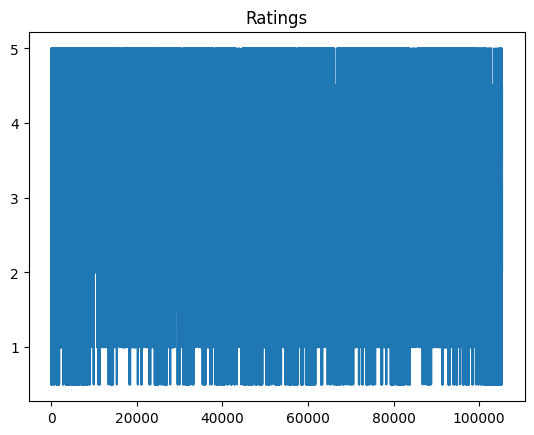

In [6]:
ratings_df.rating.plot(kind='line', title='Ratings', use_index=False)

### Ploting the genres

<AxesSubplot:title={'center':'Genres'}>

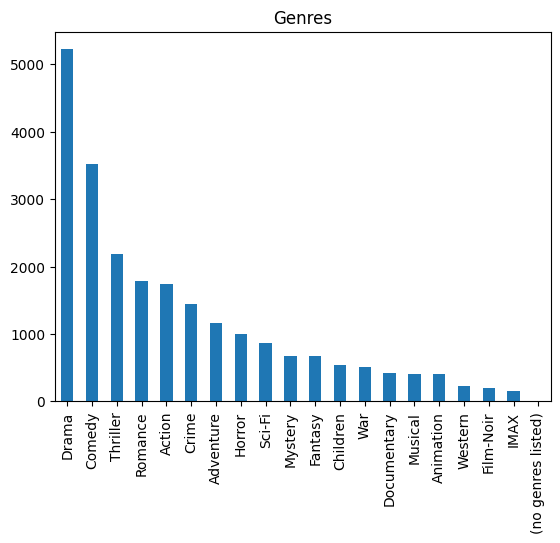

In [7]:
genres = movies_df.assign(genres=movies_df.genres.str.split("|")).explode('genres')
genres.genres.value_counts().plot(kind='bar', title='Genres')

### Plotting the active users

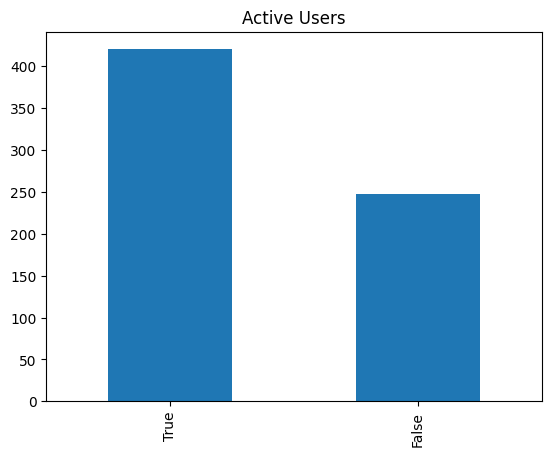

In [8]:
user_score_df = ratings_df[['user_id', 'rating']]
user_score_df = user_score_df.groupby('user_id').count()
user_score_df['is_active_user'] = user_score_df['rating'].map(lambda x: x > 50)
user_score_df['is_active_user'].value_counts().plot(kind='bar', title='Active Users')

### Print the maximum amount of rates of an user made

In [9]:
import functools
maxRate = functools.reduce(lambda a, b: a if a > b else b, user_score_df['rating'])
print(f'Maximum amount of rates made by a user: {maxRate}')

Maximum amount of rates made by a user: 5678


## Spark Initialization
### Importing modules and creating spark session

In [10]:
import findspark
findspark.init() 

import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.context import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.session import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

conf = SparkConf().setAppName("App")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '20g'))
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

### Setting driver memory size

In [11]:
import os
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

### Reading ratings csv with spark

In [12]:
data_schema = StructType([
    StructField('user_id',StringType(), False),
    StructField('movie_id',StringType(), False),
    StructField('rating', StringType(), False),
    StructField('timestamp', StringType(), False)
])
ratings = spark.read.csv(
    './ratings.csv', header=True, schema=data_schema
)


### Dropping unnecessary columns, showing and calculating dataframe

In [13]:
ratings = ratings.drop('timestamp')
ratings.count(),ratings.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|      16|   4.0|
|      1|      24|   1.5|
|      1|      32|   4.0|
|      1|      47|   4.0|
|      1|      50|   4.0|
|      1|     110|   4.0|
|      1|     150|   3.0|
|      1|     161|   4.0|
|      1|     165|   3.0|
|      1|     204|   0.5|
|      1|     223|   4.0|
|      1|     256|   0.5|
|      1|     260|   4.5|
|      1|     261|   1.5|
|      1|     277|   0.5|
|      1|     296|   4.0|
|      1|     318|   4.0|
|      1|     349|   4.5|
|      1|     356|   3.0|
|      1|     377|   2.5|
+-------+--------+------+
only showing top 20 rows



(105339, None)

### Converting string fields to number values

In [14]:
from pyspark.sql.types import IntegerType, FloatType
ratings = ratings.withColumn("user_id", ratings["user_id"].cast(IntegerType()))
ratings = ratings.withColumn("movie_id", ratings["movie_id"].cast(IntegerType()))
ratings = ratings.withColumn("rating", ratings["rating"].cast(FloatType()))
ratings.dtypes

[('user_id', 'int'), ('movie_id', 'int'), ('rating', 'float')]

### Train-test split

In [15]:
(training,test)=ratings.randomSplit([0.7, 0.3])

### Training als model with first parameters

In [16]:
als=ALS(rank=10,maxIter=10,regParam=0.01,
        userCol="user_id",itemCol="movie_id",ratingCol="rating",
        coldStartStrategy="drop",implicitPrefs=False,seed=5040)
model = als.fit(training)

### Collecting predictions

In [17]:
predictions = model.transform(test)

### Evaluate the RMSE

In [18]:
#predictions = model.predictAll(test)
evaluator = RegressionEvaluator(metricName = "rmse",labelCol = 'rating', predictionCol = 'prediction')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.1798585624928395


### Evaluate the MSE

In [19]:
evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Mean-square error = 1.3920662274876694


### Repeating the process for other parameters and creating different models

In [20]:
als = ALS(rank=10, maxIter=10, regParam=0.1, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Root-mean-square error = 0.9139082966652612
Mean-square error = 0.8352283747135988


In [21]:
als = ALS(rank=50, maxIter=10, regParam=0.01, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Root-mean-square error = 1.407216783583342
Mean-square error = 1.9802590759986463


In [22]:
als = ALS(rank=50, maxIter=10, regParam=0.1, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Root-mean-square error = 0.9079090676550169
Mean-square error = 0.8242988751302021


In [23]:
als = ALS(rank=200, maxIter=10, regParam=0.01, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Root-mean-square error = 1.5060058378520607
Mean-square error = 2.2680535836444884


In [24]:
als = ALS(rank=200, maxIter=10, regParam=0.1, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

evaluator2 = RegressionEvaluator(metricName = "mse",labelCol = 'rating', predictionCol = 'prediction')
mse = evaluator2.evaluate(predictions)
print("Mean-square error = " + str(mse))

Root-mean-square error = 0.9067744654058514
Mean-square error = 0.8222399311120676


### The best model is the last model with the rank value of 200, iteration value of 10 and lambda of 0.1

### Converting predictions to pandas dataframe

In [25]:
predictions = predictions.toPandas()

### Plotting the accuracy of predictions with using rating values

<AxesSubplot:title={'center':'Comparing Predictions'}, xlabel='rating', ylabel='prediction'>

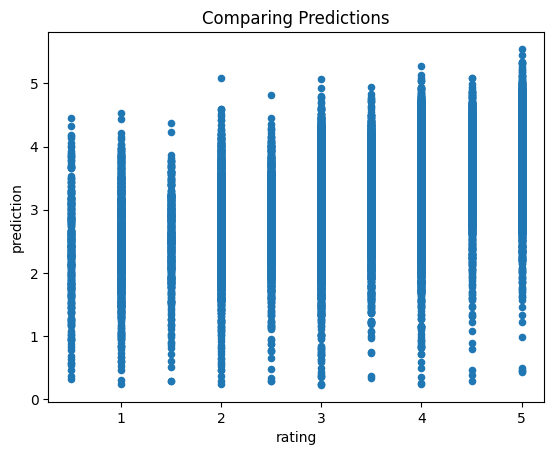

In [26]:
predictions.plot.scatter(x="rating",y="prediction",title="Comparing Predictions")

### Definining cosine similarity and computing algorithm

In [27]:
def cosineSimilarity(a,b):
    dot = np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma*normb)
    return cos

In [28]:
from pyspark.sql import Row
from pyspark.sql import SQLContext

def compute_similarity(itemFactors, movie_id):
    get_movie_id = movie_id
    item = itemFactors.where(sql_func.col('id') == get_movie_id).select(sql_func.col('features'))
    item_features = item.rdd.map(lambda x: x.features).first()
    lol = []
    for row in itemFactors.rdd.toLocalIterator():
        _id = row.__getattr__('id')
        features = row.__getattr__('features')
        similarity_score = cosineSimilarity(features, item_features)
        if _id != get_movie_id:
            lol.append([_id, similarity_score])
    R = Row('item_index', 'similarity_score')
    sqlContext = SQLContext(sc)
    similar_items_df = sqlContext.createDataFrame([R(col[0], float(col[1])) for col in lol])
    return(similar_items_df)

sims = compute_similarity(model.itemFactors, 256)
sims.head()

Row(item_index=10, similarity_score=0.672382402251225)

#### Calculated the similarity for value 256
### Recommending for all items

In [29]:
user_recs=model.recommendForAllItems(10).show(10)

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|    1580|[[650, 4.7501597]...|
|    4900|[[201, 4.852497],...|
|    5300|[[78, 4.061754], ...|
|    6620|[[78, 4.721627], ...|
|    7340|[[650, 3.1410067]...|
|   27760|[[650, 2.7896075]...|
|   32460|[[17, 4.4320045],...|
|   54190|[[78, 4.141597], ...|
|   57370|[[650, 3.3974206]...|
|     471|[[637, 4.754523],...|
+--------+--------------------+
only showing top 10 rows



### Recommending for all users

In [30]:
df_recom = model.recommendForAllUsers(10)
df_recom.show(10)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    471|[[105844, 4.85300...|
|    463|[[27592, 4.481455...|
|    496|[[2118, 4.6489515...|
|    148|[[80969, 4.649794...|
|    540|[[296, 4.7835274]...|
|    392|[[8368, 4.3380494...|
|    243|[[80969, 5.452096...|
|    623|[[80969, 4.917374...|
|     31|[[80969, 4.823214...|
|    516|[[80969, 4.886602...|
+-------+--------------------+
only showing top 10 rows



### Taking top ten recommendations for all users and creating pandas dataframe

In [31]:
df_recom = df_recom.select("user_id","recommendations")
df_recom.show(10)
df_recom = df_recom.toPandas()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|    471|[[105844, 4.85300...|
|    463|[[27592, 4.481455...|
|    496|[[2118, 4.6489515...|
|    148|[[80969, 4.649794...|
|    540|[[296, 4.7835274]...|
|    392|[[8368, 4.3380494...|
|    243|[[80969, 5.452096...|
|    623|[[80969, 4.917374...|
|     31|[[80969, 4.823214...|
|    516|[[80969, 4.886602...|
+-------+--------------------+
only showing top 10 rows



### Output of recommendations

In [32]:
df_recom.sort_values('user_id')

,user_id,recommendations
145,1,"[(48516, 4.595644950866699), (1217, 4.50547122..."
599,2,"[(80969, 4.838160037994385), (105844, 4.695560..."
169,3,"[(2912, 4.729909896850586), (80969, 4.70398807..."
332,4,"[(2725, 4.832009315490723), (1085, 4.769549369..."
217,5,"[(71264, 4.73113489151001), (81847, 4.70363330..."
...,...,...
366,664,"[(52767, 4.866530895233154), (3359, 4.85053682..."
128,665,"[(80969, 4.356706619262695), (27700, 4.2738242..."
260,666,"[(2964, 4.9134955406188965), (1809, 4.90575790..."
58,667,"[(80969, 4.65794038772583), (296, 4.4614691734..."


### Reason why other models didn't work
The other models with iteration value of 50 and 200 are failed because of memory problems.
Output of error given below.

In [33]:
als = ALS(rank=10, maxIter=50, regParam=0.01, 
          userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop",
          seed=5040,
          implicitPrefs=False)
model = als.fit(training)

predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Py4JJavaError: An error occurred while calling o674.fit.
: org.apache.spark.SparkException: Job 68 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:837)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:835)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:835)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:1890)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:83)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:1803)
	at org.apache.spark.SparkContext$$anonfun$stop$8.apply$mcV$sp(SparkContext.scala:1931)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1361)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1930)
	at org.apache.spark.SparkContext$$anonfun$2.apply$mcV$sp(SparkContext.scala:573)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1992)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1168)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:1030)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:674)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:568)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 58943)
Traceback (most recent call last):
  File "c:\users\19180\appdata\local\programs\python\python37\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "c:\users\19180\appdata\local\programs\python\python37\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "c:\users\19180\appdata\local\programs\python\python37\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "c:\users\19180\appdata\local\programs\python\python37\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\spark\python\pyspark\accumulators.py", line 265, in handle
    poll(accum_updates)
  File "C:\spark\python\pyspark\accumulators.py", line 238, in poll
    if func():
  File "C:\spark\python\pyspark\accumulators